In [1]:

######## snakemake preamble start (automatically inserted, do not edit) ########
library(methods)
Snakemake <- setClass(
    "Snakemake",
    slots = c(
        input = "list",
        output = "list",
        params = "list",
        wildcards = "list",
        threads = "numeric",
        log = "list",
        resources = "list",
        config = "list",
        rule = "character",
        bench_iteration = "numeric",
        scriptdir = "character",
        source = "function"
    )
)
snakemake <- Snakemake(
    input = list('data/ATAC_predictions_new_split/train_normalized_gaussian_smooth_trimmed_CONTROLS_split.rds', 'data/ATAC_predictions_new_split/test_normalized_gaussian_smooth_trimmed_CONTROLS_split.rds', 'data/cases_controls/cases_controls_rds_format/all_samples_normalized_gaussian_smooth_trimmed_CASES.rds', 'data/ATACseq_250kb_bins.txt', "input_train" = 'data/ATAC_predictions_new_split/train_normalized_gaussian_smooth_trimmed_CONTROLS_split.rds', "input_test_controls" = 'data/ATAC_predictions_new_split/test_normalized_gaussian_smooth_trimmed_CONTROLS_split.rds', "input_test_cases" = 'data/cases_controls/cases_controls_rds_format/all_samples_normalized_gaussian_smooth_trimmed_CASES.rds', "input_atac" = 'data/ATACseq_250kb_bins.txt'),
    output = list('data/ATAC_predictions_train_XX_predict_XX/ATAC_pred_lasso_normalized_gaussian_smooth_trimmed.rds', 'Trained_models/train_XX_predict_XX_models/Lasso_models/lasso_normalized_gaussian_smooth_trimmed.rds', "output_pred" = 'data/ATAC_predictions_train_XX_predict_XX/ATAC_pred_lasso_normalized_gaussian_smooth_trimmed.rds', "output_model" = 'Trained_models/train_XX_predict_XX_models/Lasso_models/lasso_normalized_gaussian_smooth_trimmed.rds'),
    params = list(),
    wildcards = list('normalized_gaussian_smooth_trimmed', "suffix" = 'normalized_gaussian_smooth_trimmed'),
    threads = 1,
    log = list('logs/processed_notebooks/train_XX_predict_XX/processed_Lasso_reg_TRUE_normalized_gaussian_smooth_trimmed.r.ipynb', "notebook" = 'logs/processed_notebooks/train_XX_predict_XX/processed_Lasso_reg_TRUE_normalized_gaussian_smooth_trimmed.r.ipynb'),
    resources = list('mem_mb', 'disk_mb', 'tmpdir', 'time', "mem_mb" = 200000, "disk_mb" = 20600, "tmpdir" = '/scratch/56739907', "time" = '48:00:00'),
    config = list(),
    rule = 'ATAC_pred',
    bench_iteration = as.numeric(NA),
    scriptdir = '/faststorage/project/DELFI1/Workspaces/CarmenAndAnika/ATAC_pred_models/Train_20_predict_80_and_cases_models/Lasso_regression',
    source = function(...){
        wd <- getwd()
        setwd(snakemake@scriptdir)
        source(...)
        setwd(wd)
    }
)
setwd('/faststorage/project/DELFI1/Workspaces/CarmenAndAnika');

######## snakemake preamble end #########


# Lasso regression

In [2]:
library(tidyverse)
library(glmnet)

install.packages('glmnetUtils')
library(glmnetUtils)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-16

Updating HTML index of packages in '.Library'
Making 'packages.html' ...

### Read in data and ATAC values, add ATAC values to the dataframe

In [3]:
#all_samples_gaussian_controls <- read.csv("../../../data/cases_controls/all_samples_normalized_CASES.csv", nrows=20000)
#head(all_samples_gaussian_controls)

In [4]:
#all_samples_controls <- all_samples_gaussian_controls

In [5]:
#ATAC <- read.table("../../../data/ATACseq_250kb_bins.txt", header = FALSE)

In [6]:
#head(ATAC)

In [7]:
#all_samples_gaussian_controls <- read.csv("../../../data/all_samples_normalized_CONTROLS.csv", nrows=20000)
all_samples_controls <- readRDS(snakemake@input[["input_train"]])
head(all_samples_controls)

sample,bin,X80,X81,X82,X83,X84,X85,X86,X87,...,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400
PGDX16581P,chr10_400,7.198796e-05,7.246287e-05,7.208874e-05,6.531944e-05,5.449356e-05,5.411943e-05,5.865093e-05,8.878008e-05,...,1.605172e-04,1.835899e-04,1.941788e-04,1.875145e-04,1.694402e-04,1.421738e-04,1.143355e-04,8.778100e-05,6.078372e-05,4.400544e-05
PGDX16581P,chr10_40,5.998776e-05,5.463206e-05,4.518424e-05,4.051466e-05,3.838886e-05,4.387149e-05,5.319238e-05,6.673060e-05,...,8.528553e-05,9.891692e-05,1.182443e-04,1.285240e-04,1.444602e-04,1.489320e-04,1.444602e-04,1.285240e-04,1.115015e-04,8.669145e-05
PGDX16581P,chr10_4,4.224835e-05,5.229096e-05,6.587628e-05,8.543292e-05,1.317474e-04,1.782478e-04,2.263839e-04,2.697975e-04,...,7.773202e-05,3.992690e-05,1.231115e-05,6.790087e-06,0.000000e+00,6.790087e-06,1.231115e-05,1.955664e-05,2.721841e-05,3.318973e-05
PGDX16581P,chr10_401,5.048634e-05,5.543564e-05,5.543564e-05,5.671750e-05,5.305322e-05,6.161823e-05,7.175142e-05,8.894689e-05,...,5.422251e-05,4.798663e-05,4.500183e-05,4.175547e-05,4.292475e-05,4.292475e-05,4.175547e-05,3.877067e-05,3.045772e-05,3.120908e-05
PGDX16581P,chr10_402,2.782947e-05,3.393486e-05,4.319684e-05,4.652239e-05,4.782517e-05,4.782517e-05,5.346492e-05,6.966943e-05,...,5.257893e-05,4.735953e-05,4.087738e-05,3.625431e-05,3.393486e-05,3.477200e-05,3.952576e-05,4.517077e-05,5.476769e-05,6.176433e-05
PGDX16581P,chr10_403,5.150203e-05,5.655089e-05,5.655089e-05,5.150203e-05,4.259551e-05,3.819347e-05,4.254597e-05,5.923953e-05,...,1.807880e-04,1.871591e-04,1.847589e-04,1.670676e-04,1.353725e-04,1.173729e-04,1.046374e-04,8.607716e-05,8.757182e-05,8.838784e-05


In [8]:
#ATAC <- read.table("../../../data/ATACseq_250kb_bins.txt", header = FALSE)
ATAC <- read.table(snakemake@input[["input_atac"]], header = FALSE)

colnames(ATAC) <- c("bin", "ATAC_observed")
head(ATAC)

ATAC$ATAC_observed <- as.character(ATAC$ATAC_observed)
ATAC$ATAC_observed <- as.numeric(ATAC$ATAC_observed)
ATAC$bin <- as.character(ATAC$bin)

all_samples_ATAC_controls <- inner_join(all_samples_controls, ATAC, by="bin")

head(all_samples_ATAC_controls)

bin,ATAC_observed
chr1_0,0.05376791
chr10_0,0.29698782
chr10_1,0.40893151
chr10_10,0.30582283
chr10_100,0.59316570
chr10_101,0.47641373


Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message:
“Column `bin` joining factor and character vector, coercing into character vector”

sample,bin,X80,X81,X82,X83,X84,X85,X86,X87,...,X392,X393,X394,X395,X396,X397,X398,X399,X400,ATAC_observed
PGDX16581P,chr10_400,7.198796e-05,7.246287e-05,7.208874e-05,6.531944e-05,5.449356e-05,5.411943e-05,5.865093e-05,8.878008e-05,...,1.835899e-04,1.941788e-04,1.875145e-04,1.694402e-04,1.421738e-04,1.143355e-04,8.778100e-05,6.078372e-05,4.400544e-05,0.5866651
PGDX16581P,chr10_40,5.998776e-05,5.463206e-05,4.518424e-05,4.051466e-05,3.838886e-05,4.387149e-05,5.319238e-05,6.673060e-05,...,9.891692e-05,1.182443e-04,1.285240e-04,1.444602e-04,1.489320e-04,1.444602e-04,1.285240e-04,1.115015e-04,8.669145e-05,0.1996134
PGDX16581P,chr10_4,4.224835e-05,5.229096e-05,6.587628e-05,8.543292e-05,1.317474e-04,1.782478e-04,2.263839e-04,2.697975e-04,...,3.992690e-05,1.231115e-05,6.790087e-06,0.000000e+00,6.790087e-06,1.231115e-05,1.955664e-05,2.721841e-05,3.318973e-05,0.5968816
PGDX16581P,chr10_401,5.048634e-05,5.543564e-05,5.543564e-05,5.671750e-05,5.305322e-05,6.161823e-05,7.175142e-05,8.894689e-05,...,4.798663e-05,4.500183e-05,4.175547e-05,4.292475e-05,4.292475e-05,4.175547e-05,3.877067e-05,3.045772e-05,3.120908e-05,0.2905764
PGDX16581P,chr10_402,2.782947e-05,3.393486e-05,4.319684e-05,4.652239e-05,4.782517e-05,4.782517e-05,5.346492e-05,6.966943e-05,...,4.735953e-05,4.087738e-05,3.625431e-05,3.393486e-05,3.477200e-05,3.952576e-05,4.517077e-05,5.476769e-05,6.176433e-05,0.2319729
PGDX16581P,chr10_403,5.150203e-05,5.655089e-05,5.655089e-05,5.150203e-05,4.259551e-05,3.819347e-05,4.254597e-05,5.923953e-05,...,1.871591e-04,1.847589e-04,1.670676e-04,1.353725e-04,1.173729e-04,1.046374e-04,8.607716e-05,8.757182e-05,8.838784e-05,0.2262170


In [9]:
ATAC_val <- all_samples_ATAC_controls %>% select(ATAC_observed)
controls_predictions <- all_samples_ATAC_controls %>% select(sample, bin)
all_samples_ATAC_controls = all_samples_ATAC_controls %>% select(-c(ATAC_observed, sample, bin))

head(all_samples_ATAC_controls)
head(ATAC_val)

X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,...,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400
7.198796e-05,7.246287e-05,7.208874e-05,6.531944e-05,5.449356e-05,5.411943e-05,5.865093e-05,8.878008e-05,1.218418e-04,0.0001903253,...,1.605172e-04,1.835899e-04,1.941788e-04,1.875145e-04,1.694402e-04,1.421738e-04,1.143355e-04,8.778100e-05,6.078372e-05,4.400544e-05
5.998776e-05,5.463206e-05,4.518424e-05,4.051466e-05,3.838886e-05,4.387149e-05,5.319238e-05,6.673060e-05,8.713858e-05,0.0001133020,...,8.528553e-05,9.891692e-05,1.182443e-04,1.285240e-04,1.444602e-04,1.489320e-04,1.444602e-04,1.285240e-04,1.115015e-04,8.669145e-05
4.224835e-05,5.229096e-05,6.587628e-05,8.543292e-05,1.317474e-04,1.782478e-04,2.263839e-04,2.697975e-04,3.085372e-04,0.0003395097,...,7.773202e-05,3.992690e-05,1.231115e-05,6.790087e-06,0.000000e+00,6.790087e-06,1.231115e-05,1.955664e-05,2.721841e-05,3.318973e-05
5.048634e-05,5.543564e-05,5.543564e-05,5.671750e-05,5.305322e-05,6.161823e-05,7.175142e-05,8.894689e-05,1.129045e-04,0.0001401111,...,5.422251e-05,4.798663e-05,4.500183e-05,4.175547e-05,4.292475e-05,4.292475e-05,4.175547e-05,3.877067e-05,3.045772e-05,3.120908e-05
2.782947e-05,3.393486e-05,4.319684e-05,4.652239e-05,4.782517e-05,4.782517e-05,5.346492e-05,6.966943e-05,9.299068e-05,0.0001208254,...,5.257893e-05,4.735953e-05,4.087738e-05,3.625431e-05,3.393486e-05,3.477200e-05,3.952576e-05,4.517077e-05,5.476769e-05,6.176433e-05
5.150203e-05,5.655089e-05,5.655089e-05,5.150203e-05,4.259551e-05,3.819347e-05,4.254597e-05,5.923953e-05,7.997777e-05,0.0001066957,...,1.807880e-04,1.871591e-04,1.847589e-04,1.670676e-04,1.353725e-04,1.173729e-04,1.046374e-04,8.607716e-05,8.757182e-05,8.838784e-05


ATAC_observed
0.5866651
0.1996134
0.5968816
0.2905764
0.2319729
0.2262170


## Lasso regression

## Cross validation to find the best lambda and alpha

## Fit the model on 20% of controls

In [10]:
get_cvm <- function(model) {
   index <- match(model$lambda.min, model$lambda)
  model$cvm[index]
}

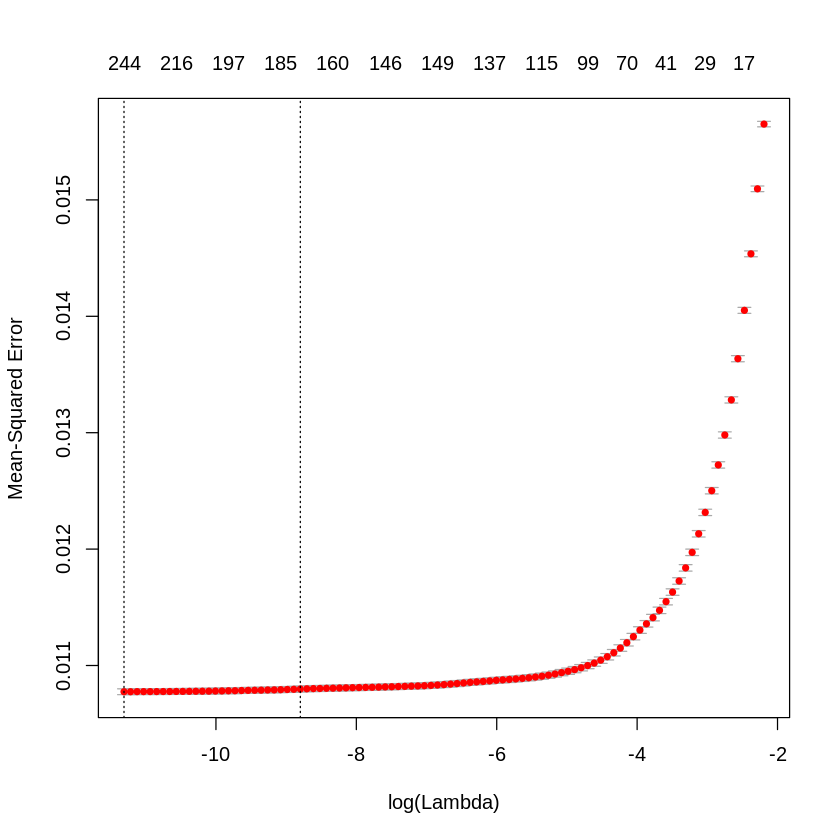

In [11]:
y <- ATAC_val %>% as.matrix()
X <- all_samples_ATAC_controls %>% as.matrix()

######### finding the best alpha #########
set.seed(0)
lasso_cva <- cva.glmnet(X, y, nfolds = 10)
enet_performance <- data.frame(alpha = lasso_cva$alpha)
models <- lasso_cva$modlist
enet_performance$cvm <- vapply(models, get_cvm, numeric(1))

minix <- which.min(enet_performance$cvm)
best_alpha <- lasso_cva$alpha[minix]
###########################################

######### finding the best lambda #########
set.seed(0)
lasso_cv <- cv.glmnet(X, y, alpha = best_alpha,
                      standardize = TRUE, nfolds = 10)

plot(lasso_cv)

###########################################


In [12]:
(lambda_cv <- lasso_cv$lambda.min)

[1] 1.225194e-05

In [13]:
y <- ATAC_val %>% as.matrix()
X <- all_samples_ATAC_controls %>% as.matrix()

fit       <- glmnet(X, y, alpha = best_alpha, lambda = lambda_cv, standardize = TRUE)
# saving the model
saveRDS(fit, snakemake@output[["output_model"]])

## Predict on 80% normalized controls and all the cases using the model (fitted on train controls) and save the predictions to the file

In [14]:
#filename = "../../../data/all_samples_normalized_CASES.csv"
#test_data = readRDS("../../data/20_80_splits/20_all_samples_normalized_CONTROLS.rds")

test_data_80_controls = readRDS(snakemake@input[["input_test_controls"]])
test_data_cases = readRDS(snakemake@input[["input_test_cases"]])

In [15]:
head(test_data_80_controls)
head(test_data_cases)

sample,bin,X80,X81,X82,X83,X84,X85,X86,X87,...,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400
PGDX16568P,chr10_400,2.656112e-05,2.994814e-05,2.961085e-05,2.929903e-05,3.469718e-05,3.917019e-05,4.629696e-05,5.955899e-05,...,1.797668e-04,1.753154e-04,1.569416e-04,0.0001385816,1.166854e-04,9.841735e-05,8.478873e-05,7.355554e-05,6.464917e-05,7.007278e-05
PGDX16568P,chr10_40,2.639605e-05,3.960356e-05,5.284513e-05,6.279401e-05,6.650374e-05,6.279401e-05,5.284513e-05,3.960356e-05,...,1.239199e-04,1.143096e-04,1.096515e-04,0.0001061073,1.087833e-04,1.047829e-04,9.925148e-05,8.919007e-05,7.883794e-05,7.639961e-05
PGDX16568P,chr10_4,4.192713e-05,6.023358e-05,7.256827e-05,7.906282e-05,7.854465e-05,7.167697e-05,7.860718e-05,8.606324e-05,...,1.251224e-04,1.238579e-04,1.192868e-04,0.0001246347,1.214730e-04,1.148990e-04,1.029420e-04,8.920670e-05,7.138334e-05,5.295770e-05
PGDX16568P,chr10_401,0.000000e+00,0.000000e+00,0.000000e+00,5.920236e-06,1.073402e-05,1.705132e-05,3.557204e-05,5.040596e-05,...,2.383188e-04,2.242108e-04,1.921067e-04,0.0001600517,1.301008e-04,1.037432e-04,8.040869e-05,7.337752e-05,8.314214e-05,8.566120e-05
PGDX16568P,chr10_402,2.723749e-05,3.321301e-05,3.548313e-05,3.321301e-05,2.723749e-05,2.636520e-05,3.143441e-05,4.547983e-05,...,3.955727e-05,3.316005e-05,2.463956e-05,0.0000263652,4.082719e-05,7.144226e-05,9.926339e-05,1.268287e-04,1.481385e-04,1.569626e-04
PGDX16568P,chr10_403,3.026954e-05,3.233848e-05,3.026954e-05,2.482360e-05,1.783596e-05,1.122795e-05,1.857799e-05,2.245591e-05,...,2.366995e-04,2.341484e-04,2.196942e-04,0.0002026050,1.707937e-04,1.339162e-04,9.654238e-05,6.627284e-05,4.648453e-05,3.525657e-05


sample,bin,X80,X81,X82,X83,X84,X85,X86,X87,...,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400
PGDX10344P1,chr10_400,2.635648e-05,2.551240e-05,3.041764e-05,3.743369e-05,4.529382e-05,7.822038e-05,1.088130e-04,1.352074e-04,...,0.0002692328,0.0002645551,0.0002411552,0.0002046561,0.0001627598,1.337986e-04,0.0001030308,9.631365e-05,9.505189e-05,1.074471e-04
PGDX10344P1,chr10_40,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.063345e-06,1.461970e-05,3.128720e-05,5.500537e-05,...,0.0001944052,0.0001867330,0.0001802170,0.0001743696,0.0001920661,1.991633e-04,0.0002152961,2.191585e-04,2.233594e-04,2.137830e-04
PGDX10344P1,chr10_4,5.872179e-05,5.289260e-05,5.340677e-05,5.454810e-05,6.798495e-05,7.621979e-05,8.256314e-05,9.338255e-05,...,0.0002578428,0.0002614286,0.0002683933,0.0002580492,0.0002405518,2.035011e-04,0.0001702625,1.276962e-04,9.172705e-05,7.422905e-05
PGDX10344P1,chr10_401,8.180537e-05,8.398114e-05,8.175570e-05,8.748995e-05,9.207371e-05,9.639651e-05,1.133106e-04,1.224668e-04,...,0.0002087284,0.0001672440,0.0001206191,0.0000962458,0.0000869615,9.938756e-05,0.0001326077,1.601019e-04,1.795923e-04,1.772339e-04
PGDX10344P1,chr10_402,1.476717e-05,2.345811e-05,4.079304e-05,5.457810e-05,6.599014e-05,7.245930e-05,8.060398e-05,8.075730e-05,...,0.0004394529,0.0004394405,0.0004194749,0.0003816848,0.0003506651,3.193917e-04,0.0002856203,2.735742e-04,2.720397e-04,2.660698e-04
PGDX10344P1,chr10_403,6.067274e-05,8.155138e-05,9.276169e-05,9.578039e-05,1.061449e-04,1.155964e-04,1.242783e-04,1.345972e-04,...,0.0001596542,0.0001474896,0.0001478111,0.0001549740,0.0001742598,2.056872e-04,0.0002243287,2.385956e-04,2.456770e-04,2.395614e-04


In [16]:
test_data_80_controls_samples_bin_rm <- test_data_80_controls %>% select(-c("sample", "bin")) %>% as.matrix()
pred_80_controls <- as.vector(predict(fit, s=lambda_cv, test_data_80_controls_samples_bin_rm))

test_data_cases_samples_bin_rm <- test_data_cases %>% select(-c("sample", "bin")) %>% as.matrix()
pred_cases <- as.vector(predict(fit, s=lambda_cv, test_data_cases_samples_bin_rm))

In [17]:
pred_tibble_80_controls <- tibble(sample = test_data_80_controls$sample, bin = test_data_80_controls$bin)
pred_tibble_80_controls <- inner_join(pred_tibble_80_controls, ATAC, by="bin")
pred_tibble_80_controls <- pred_tibble_80_controls %>% mutate(ATAC_predicted = pred_80_controls)

pred_tibble_cases <- tibble(sample = test_data_cases$sample, bin = test_data_cases$bin)
pred_tibble_cases <- inner_join(pred_tibble_cases, ATAC, by="bin")
pred_tibble_cases <- pred_tibble_cases %>% mutate(ATAC_predicted = pred_cases)

pred_tibble <- rbind(pred_tibble_80_controls, pred_tibble_cases)

Warning message:
“Column `bin` joining factor and character vector, coercing into character vector”Warning message:
“Column `bin` joining factor and character vector, coercing into character vector”

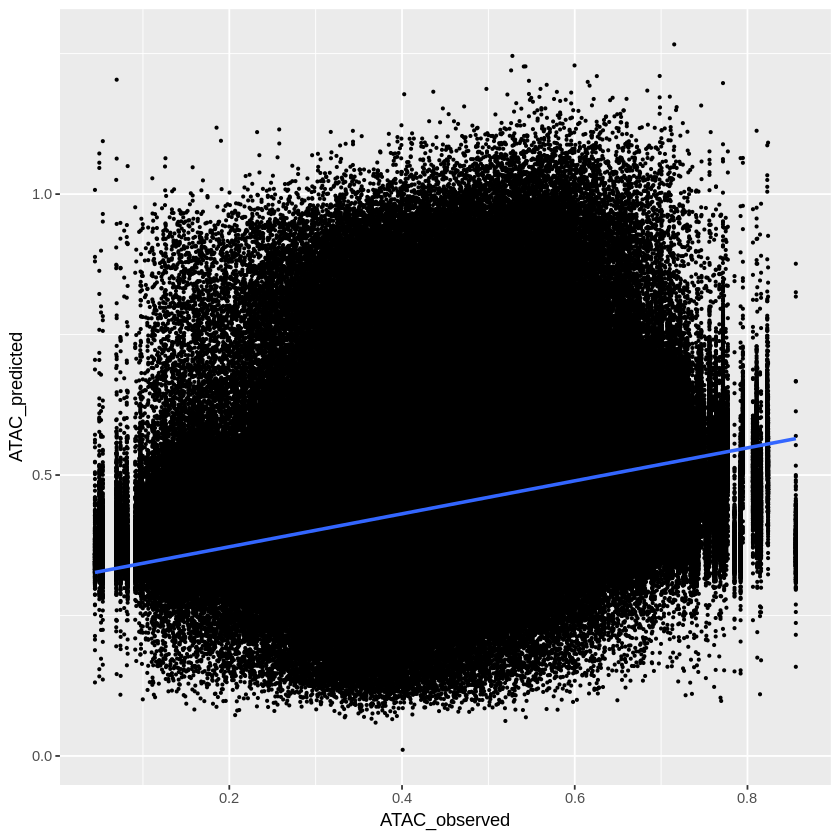

In [18]:
ggplot(pred_tibble, aes(x = ATAC_observed, y = ATAC_predicted)) + 
    geom_point(size = 0.5) + 
    geom_smooth(method = "lm", formula = y~x)

## Cor, MAE, RMSE -- all predictions

In [19]:
cor(pred_tibble$ATAC_observed, pred_tibble$ATAC_predicted)

[1] 0.4179578

In [20]:
ae    <- abs(pred_tibble$ATAC_observed - pred_tibble$ATAC_predicted)
(mae   <- mean(ae))

[1] 0.09005587

In [21]:
se    <- (pred_tibble$ATAC_observed - pred_tibble$ATAC_predicted)^2
mse   <- mean(se)
(rmse <- sqrt(mse))

[1] 0.1193863

## Cor, MAE, RMSE -- 80% of the controls predictions

In [22]:
cor(pred_tibble_80_controls$ATAC_observed, pred_tibble_80_controls$ATAC_predicted)

[1] 0.5393349

In [23]:
ae    <- abs(pred_tibble_80_controls$ATAC_observed - pred_tibble_80_controls$ATAC_predicted)
(mae   <- mean(ae))

[1] 0.08189165

In [24]:
se    <- (pred_tibble_80_controls$ATAC_observed - pred_tibble_80_controls$ATAC_predicted)^2
mse   <- mean(se)
(rmse <- sqrt(mse))

[1] 0.10548

## Cor, MAE, RMSE -- cases predictions

In [25]:
cor(pred_tibble_cases$ATAC_observed, pred_tibble_cases$ATAC_predicted)

[1] 0.3581041

In [26]:
ae    <- abs(pred_tibble_cases$ATAC_observed - pred_tibble_cases$ATAC_predicted)
(mae   <- mean(ae))

[1] 0.0969422

In [27]:
se    <- (pred_tibble_cases$ATAC_observed - pred_tibble_cases$ATAC_predicted)^2
mse   <- mean(se)
(rmse <- sqrt(mse))

[1] 0.1299642

## Save predictions

In [28]:
saveRDS(pred_tibble, file = snakemake@output[["output_pred"]])